In [1]:
import numpy as np
import os
import sys
import copy

import torch
torch.set_num_threads(os.cpu_count())
from torch import nn

import pickle as pk

import matplotlib as mpl
import matplotlib.pyplot as plt

from pipnet import data
from pipnet import model
from pipnet import utils

device = "cuda" if torch.cuda.is_available() else "cpu"

np.random.seed(1)

In [2]:
comparison = "layers"

if comparison == "layers":
    
    mods = [
        "PIPNet_2022_11_21_2_layers",
        "PIPNet_2022_11_21_3_layers",
        "PIPNet_2022_11_21_4_layers",
    ]

    labels = ["2 layers", "3 layers", "4 layers"]

else:
    raise ValueError(f"Unknown comparison: {comparison}")
    
in_root = f"../../figures/2D/"

fig_dir = f"../../figures/2D/compare_{comparison}/"

if not os.path.exists(fig_dir):
    os.mkdir(fig_dir)

In [3]:
evaluations = []
evaluation_keys = []
for mod in mods:
    
    mod_evaluations = {}
    mod_evaluation_keys = {}
    
    print(f"Loading {mod}")
    
    for f in sorted(os.listdir(f"{in_root}{mod}/evaluation/")):
        if f.startswith("eval_") and f.endswith(".txt"):
            with open(f"{in_root}{mod}/evaluation/{f}", "r") as F:
                lines = F.read().split("\n")
            
            ev = f.split("eval_")[1].split(".txt")[0]
            
            mod_evaluations[ev] = []
            mod_evaluation_keys[ev] = []
            for l in lines:
                if len(l) > 0:
                    tmp = l.split()
                    try:
                        if ev == "npeaks":
                            mod_evaluation_keys[ev].append(float(tmp[0])**2)
                        else:
                            mod_evaluation_keys[ev].append(float(tmp[0]))
                    except:
                        mod_evaluation_keys[ev].append(tmp[0])
                    
                    mod_evaluations[ev].append(list(map(float, tmp[1:])))
            
            mod_evaluations[ev] = np.array(mod_evaluations[ev])
            
    evaluations.append(mod_evaluations)
    evaluation_keys.append(mod_evaluation_keys)

Loading PIPNet_2022_11_21_2_layers
Loading PIPNet_2022_11_21_3_layers
Loading PIPNet_2022_11_21_4_layers


In [4]:
for k in evaluation_keys[-1]:
    
    fig = plt.figure(figsize=(8,6))
    ax1 = fig.add_subplot(2,2,1)
    ax2 = fig.add_subplot(2,2,2)
    ax3 = fig.add_subplot(2,2,3)
    ax4 = fig.add_subplot(2,2,4)

    fig2 = plt.figure(figsize=(8,6))
    ax12 = fig2.add_subplot(2,2,1)
    ax22 = fig2.add_subplot(2,2,2)
    ax32 = fig2.add_subplot(2,2,3)
    ax42 = fig2.add_subplot(2,2,4)
    
    max_errs = [0., 0., 0., 0.]
    max_errs_norm = [0., 0., 0., 0.]
    for i, (evk, ev) in enumerate(zip(evaluation_keys, evaluations)):
        ax1.plot(evk[k], ev[k][:, 0], f"C{i}.-")
        ax2.plot(evk[k], ev[k][:, 1], f"C{i}.-")
        ax3.plot(evk[k], ev[k][:, 2], f"C{i}.-")
        ax4.plot(evk[k], ev[k][:, 3], f"C{i}.-")
        
        m = np.max(ev[k][:, :4], axis=0)
        max_errs[0] = max(max_errs[0], m[0])
        max_errs[1] = max(max_errs[1], m[1])
        max_errs[2] = max(max_errs[2], m[2])
        max_errs[3] = max(max_errs[3], m[3])
                
        if ev[k].shape[1] > 4:
            ax12.plot(evk[k], ev[k][:, 0] / evk[k], f"C{i}.-")
            ax22.plot(evk[k], ev[k][:, 1] / evk[k], f"C{i}.-")
            ax32.plot(evk[k], ev[k][:, 2] / evk[k], f"C{i}.-")
            ax42.plot(evk[k], ev[k][:, 3] / evk[k], f"C{i}.-")
        
            m = np.max(ev[k][:, 4:], axis=0)
            max_errs_norm[0] = max(max_errs_norm[0], m[0])
            max_errs_norm[1] = max(max_errs_norm[1], m[1])
            max_errs_norm[2] = max(max_errs_norm[2], m[2])
            max_errs_norm[3] = max(max_errs_norm[3], m[3])
            
    ax1.set_ylabel("Spectrum MAE")
    ax2.set_ylabel("Integral MAE")
    ax3.set_ylabel("Spectrum MSE")
    ax4.set_ylabel("Cosine similarity")
    
    ax1.set_xlabel(f"{k}")
    ax2.set_xlabel(f"{k}")
    ax3.set_xlabel(f"{k}")
    ax4.set_xlabel(f"{k}")
    
    if k == "noise" or k == "lw_noise":
        ax1.set_xscale("log")
        ax2.set_xscale("log")
        ax3.set_xscale("log")
        ax4.set_xscale("log")
    
    ax1.set_ylim(0., max_errs[0] * 1.1)
    ax2.set_ylim(0., max_errs[1] * 1.1)
    ax3.set_ylim(0., max_errs[2] * 1.1)
    ax4.set_ylim(0., max_errs[3] * 1.1)
    
    ax2.legend(labels)
    
    fig.tight_layout()
    fig.savefig(f"{fig_dir}compare_{k}.pdf")
    plt.close(fig) 
        
    if ev[k].shape[1] > 4:
        ax12.set_ylabel("Spectrum MAE")
        ax22.set_ylabel("Integral MAE")
        ax32.set_ylabel("Spectrum MSE")
        ax42.set_ylabel("Cosine similarity")

        ax12.set_xlabel(f"{k}")
        ax22.set_xlabel(f"{k}")
        ax32.set_xlabel(f"{k}")
        ax42.set_xlabel(f"{k}")
    
        ax12.set_ylim(0., max_errs_norm[0] * 1.1)
        ax22.set_ylim(0., max_errs_norm[1] * 1.1)
        ax32.set_ylim(0., max_errs_norm[2] * 1.1)
        ax42.set_ylim(0., max_errs_norm[3] * 1.1)

        ax22.legend(labels)

        fig2.tight_layout()
        fig2.savefig(f"{fig_dir}compare_{k}_norm.pdf")

    plt.close(fig2)

In [5]:
keys = evaluation_keys[0]["wr12"]
keys.append(evaluation_keys[0]["constant"][1])
print(keys)
all_evs = []
for ev in evaluations:
    evs = ev["wr12"]
    evs = np.append(evs, ev["constant"][1][None, :], axis=0)
    all_evs.append(evs)

['wr1', 'wr2', 'wr1+wr2', 'Constant']


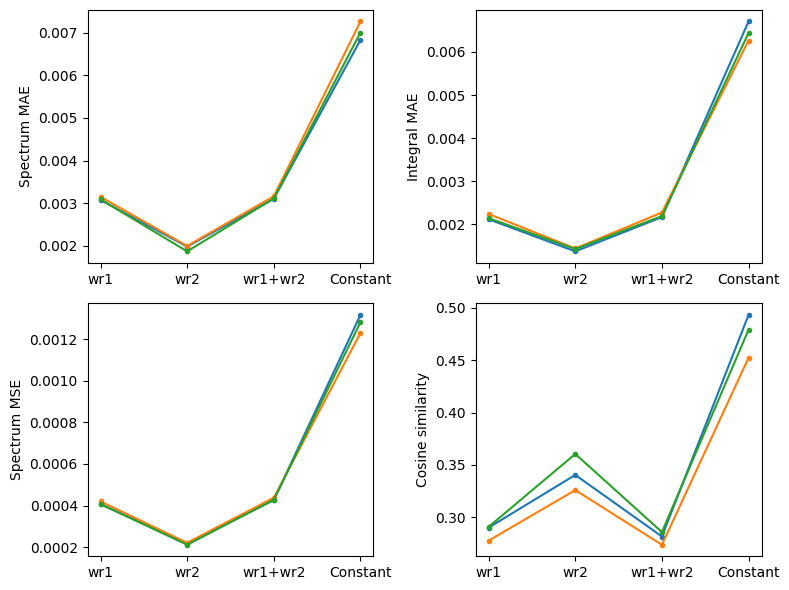

In [6]:
mod = "final_model"

fig = plt.figure(figsize=(8,6))
ax1 = fig.add_subplot(2,2,1)
ax2 = fig.add_subplot(2,2,2)
ax3 = fig.add_subplot(2,2,3)
ax4 = fig.add_subplot(2,2,4)

max_errs = [0., 0., 0., 0.]
max_errs_norm = [0., 0., 0., 0.]

for i, evs in enumerate(all_evs):
    ax1.plot(keys, evs[:, 0], f"C{i}.-")
    ax2.plot(keys, evs[:, 1], f"C{i}.-")
    ax3.plot(keys, evs[:, 2], f"C{i}.-")
    ax4.plot(keys, evs[:, 3], f"C{i}.-")

ax1.set_ylabel("Spectrum MAE")
ax2.set_ylabel("Integral MAE")
ax3.set_ylabel("Spectrum MSE")
ax4.set_ylabel("Cosine similarity")

#ax1.set_ylim(0., max_errs[0] * 1.1)
#ax2.set_ylim(0., max_errs[1] * 1.1)
#ax3.set_ylim(0., max_errs[2] * 1.1)
#ax4.set_ylim(0., max_errs[3] * 1.1)

fig.tight_layout()
fig.savefig(f"{fig_dir}final_model_wr_dependence.pdf")
plt.show()
plt.close()